#Proyecto Final Final

**Nombre:** Sebastian Tienda Tienda

**Técnicas Estadísticas y Minería de Datos**

**Facultad de Estudios Superiores Acatlán**


#Modelos Predictivos en Marketing Bancario: Eficiencia de la Regresión Logística en la Clasificación de Clientes

In [1]:
#Cargamos los paquetes que vamos a usar
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00


In [52]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pandas as pd
#Cargamos el Dataset desde Github
url_datos = "https://raw.githubusercontent.com/sebastiantienda/Base-para-Proyecto-Miner-a-de-Datos/main/bank-full.csv"
#Nombramos el dataset
df = pd.read_csv(url_datos, sep=';')
#Mostramos los primeros 5 datos
df.head()



,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [53]:
#Mostramos las dimensiones de nuestro Dataset
df.shape


(45211, 17)

In [54]:
#Mostramos el nombre de las columnas de nuestro data set
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [55]:
#Observamos la cantidad de registros nulos que hay en el DataFrame
df.isnull().mean()*100

,0
age,0.0
job,0.0
marital,0.0
education,0.0
default,0.0
balance,0.0
housing,0.0
loan,0.0
contact,0.0
day,0.0


No hay ningun dato null

In [56]:

#Mostramos la infomación de las columas datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


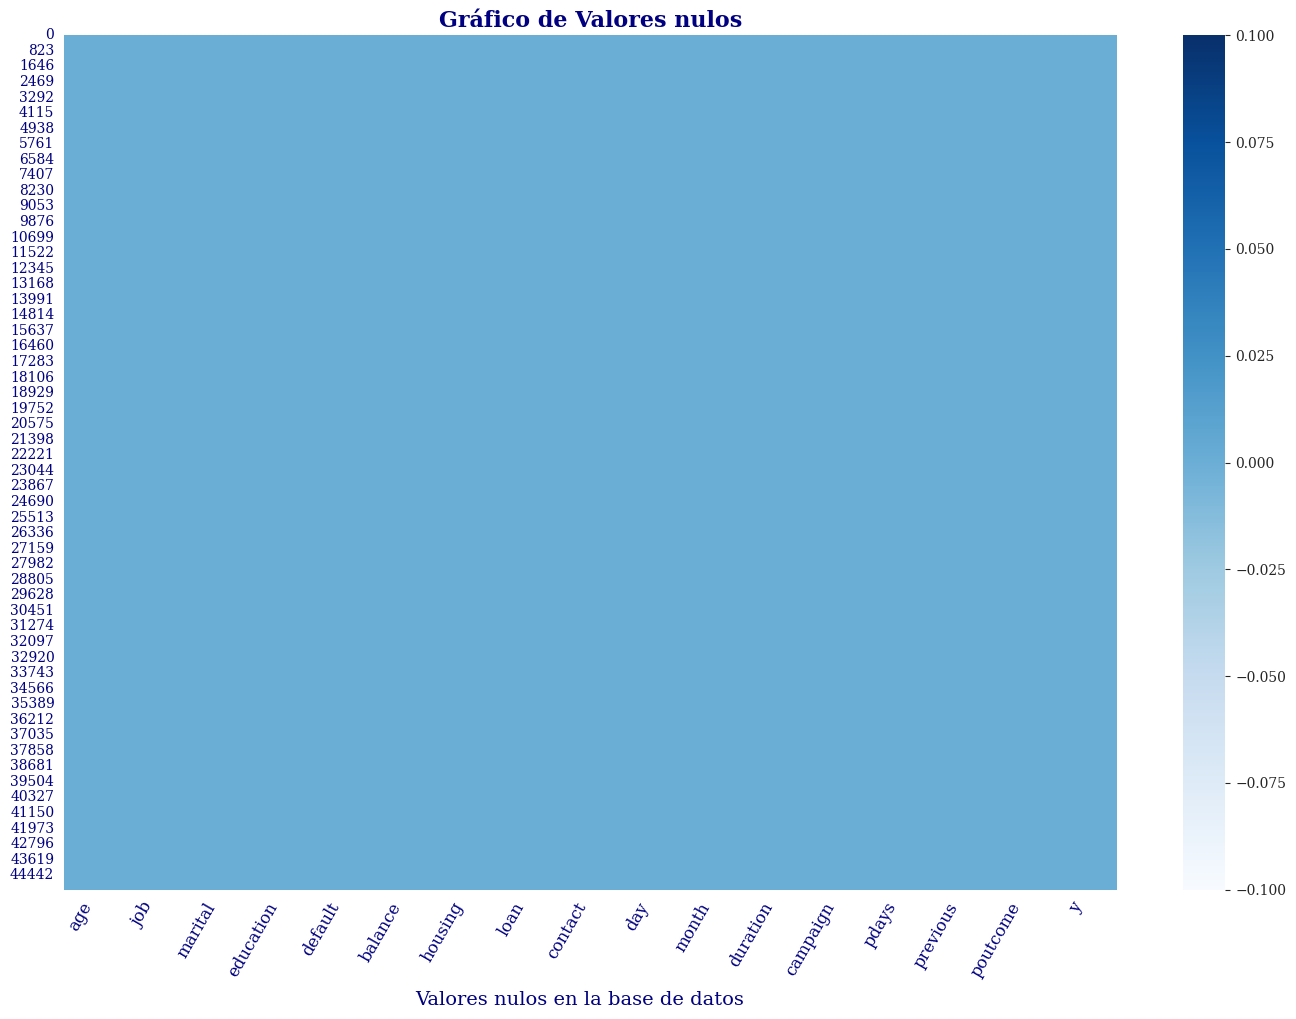

In [57]:
#El siguiente gráfico nos permite visualizar la cantidad de valores nulos que hay en nuestro dataset
# facecolor--> color  de fondo
plt.figure(figsize=(14,10), facecolor = 'white')
#Tipo de letra para el gráfico
plt.rcParams['font.family'] = 'DejaVu Serif'
#Grafico para ver la proporción de valores nulos
sns.heatmap(df.isnull(), cmap = 'Blues')

# Agregamos el título
#fontweight='bold'-->Negritas
plt.title('Gráfico de Valores nulos',
          fontsize=16, color ='navy', fontweight = 'bold')
#Agregamos las etiquetas de los valores del eje X
plt.xticks(fontsize=12, color='navy',rotation=60, ha='right')
plt.yticks(fontsize=10, color='navy')
#Agregamos la interpretacion de la grafica
plt.figtext(0.3, -0.01, "Valores nulos en la base de datos",
            fontsize = 14, color='navy')
#Mostramos el gráfico
plt.tight_layout()
plt.show()

Confirmamos que no hay datos nulos

In [58]:
#Quitamos la variable Duration
df.drop(columns=['duration'], inplace=True)


In [59]:
#Verificamos
df.columns


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'y'],
      dtype='object')

La variable duration se excluye porque genera data leakage, ya que solo se conoce después de la llamada telefónica y no está disponible al momento de la predicción. Su inclusión produciría un modelo con desempeño artificialmente alto pero no aplicable en un contexto real de negocio.

In [60]:
# Cuenta la cantidad de personas que sufrieron un siniestro (1) y las que no sufrieron un siniestro (0)
df['y'].value_counts()


,count
y,
no,39922
yes,5289


La variable objetivo original y fue transformada a una variable binaria (y_bin), donde 1 indica la contratación del depósito y 0 lo contrario. Esta transformación es necesaria para la aplicación de modelos de clasificación binaria como la regresión logística.

/tmp/ipython-input-1253808939.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafica = sns.countplot(


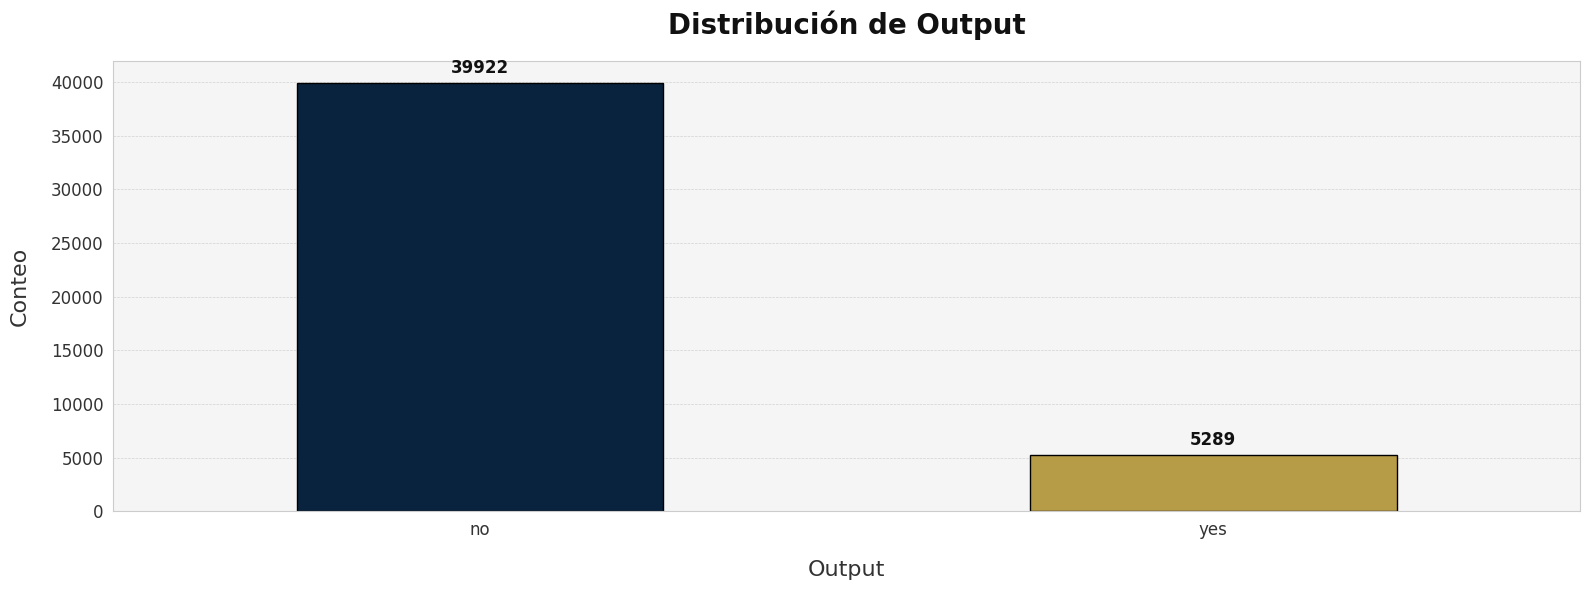

In [61]:
# Activar estilo blanco con cuadrícula
sns.set_style("whitegrid")
# Tamaño del gráfico
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(111)

# Fondo claro

fig.patch.set_facecolor('white')
ax.set_facecolor('#f5f5f5')

# Tipografía
plt.rcParams['font.family'] = 'DejaVu Sans'

# Elegimos los colores
colors = ['#002147', '#C9A635']  # Azul y verde

# Gráfico de barras
grafica = sns.countplot(
    x='y',
    data=df,
    palette=colors,
    edgecolor='black',
    linewidth=1,
    width=0.5
)

# Títulos y etiquetas con estilo claro
ax.set_xlabel('Output', fontsize=16, color='#333333', labelpad=15)
ax.set_ylabel('Conteo', fontsize=16, color='#333333', labelpad=15)
ax.set_title('Distribución de Output', fontsize=20, color='#111111', fontweight='bold', pad=20)

# Ejes
ax.tick_params(axis='x', colors='#333333', labelsize=12)
ax.tick_params(axis='y', colors='#333333', labelsize=12)

# Etiquetas sobre las barras
for container in grafica.containers:
    grafica.bar_label(
        container,
        fontsize=12,
        color='#111111',
        fontweight='bold',
        padding=4
    )

# Rejilla clara y suave
ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, color='gray', alpha=0.3)

# Márgenes y distribución
plt.tight_layout()
plt.show()

Donde $y = yes$ entones el cliente acepto el producto después de la llamada
y $y = no$ el cliente no acepto el producto después de la llamada

In [62]:
#Construimos la variable objetivo
df['y_bin'] = df['y'].map({'yes': 1, 'no': 0})


In [63]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome,y,y_bin
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,1,-1,0,unknown,no,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,1,-1,0,unknown,no,0


In [64]:
#Creamos el set para el entrenamiento
df_entrenamiento = df.copy()

In [65]:
#Variable Target
Y = df_entrenamiento['y_bin']
Y

,y_bin
0,0
1,0
2,0
3,0
4,0
...,...
45206,1
45207,1
45208,1
45209,0


In [66]:
#Borramos variables no significativas
df_entrenamiento.drop(['day', 'contact', 'housing', 'previous'], axis=1, inplace=True)

In [67]:
df.columns


Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous',
       'poutcome', 'y', 'y_bin'],
      dtype='object')

Durante la etapa de preparación de datos se realizó una evaluación conceptual y estadística de las variables disponibles con el objetivo de construir un modelo de regresión logística parsimonioso, interpretable y aplicable en un entorno real de negocio. Como resultado de este análisis, se decidió excluir las variables day, contact, housing y previous por las siguientes razones:

En primer lugar, la variable day, que representa el día del mes en el que se realizó el contacto, no contiene un significado económico ni conductual relevante. Su variación es esencialmente aleatoria y no guarda una relación estructural con la decisión del cliente de contratar un depósito a plazo fijo, por lo que su inclusión no aporta poder predictivo al modelo.

En segundo lugar, la variable contact, que indica el medio de contacto utilizado, pierde relevancia explicativa una vez que se controlan otras variables relacionadas con el historial de campañas y características del cliente. Además, no refleja una preferencia ni una decisión del cliente, sino una elección operativa del banco, lo que limita su capacidad para explicar el comportamiento de contratación.

La variable housing, que indica la existencia de un crédito hipotecario, fue excluida debido a que no presenta una relación directa ni consistente con la probabilidad de aceptación del producto analizado. Una vez incorporadas variables financieras como el balance y el historial de campañas, su efecto resulta marginal y estadísticamente no significativo, por lo que se considera redundante.

Finalmente, la variable previous, que mide el número de contactos previos, muestra una alta correlación con otras variables como pdays y poutcome, lo que introduce problemas de multicolinealidad. Su eliminación contribuye a mejorar la estabilidad de los coeficientes y la interpretabilidad del modelo sin afectar negativamente su desempeño predictivo.

En conjunto, la exclusión de estas variables permitió reducir la complejidad del modelo, evitar la incorporación de ruido estadístico y asegurar que las variables incluidas representen información relevante, disponible al momento de la predicción y alineada con el objetivo del negocio.

In [68]:
df_entrenamiento.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   loan       45211 non-null  object
 7   month      45211 non-null  object
 8   campaign   45211 non-null  int64 
 9   pdays      45211 non-null  int64 
 10  poutcome   45211 non-null  object
 11  y          45211 non-null  object
 12  y_bin      45211 non-null  int64 
dtypes: int64(5), object(8)
memory usage: 4.5+ MB


In [69]:

df_entrenamiento.shape

(45211, 13)

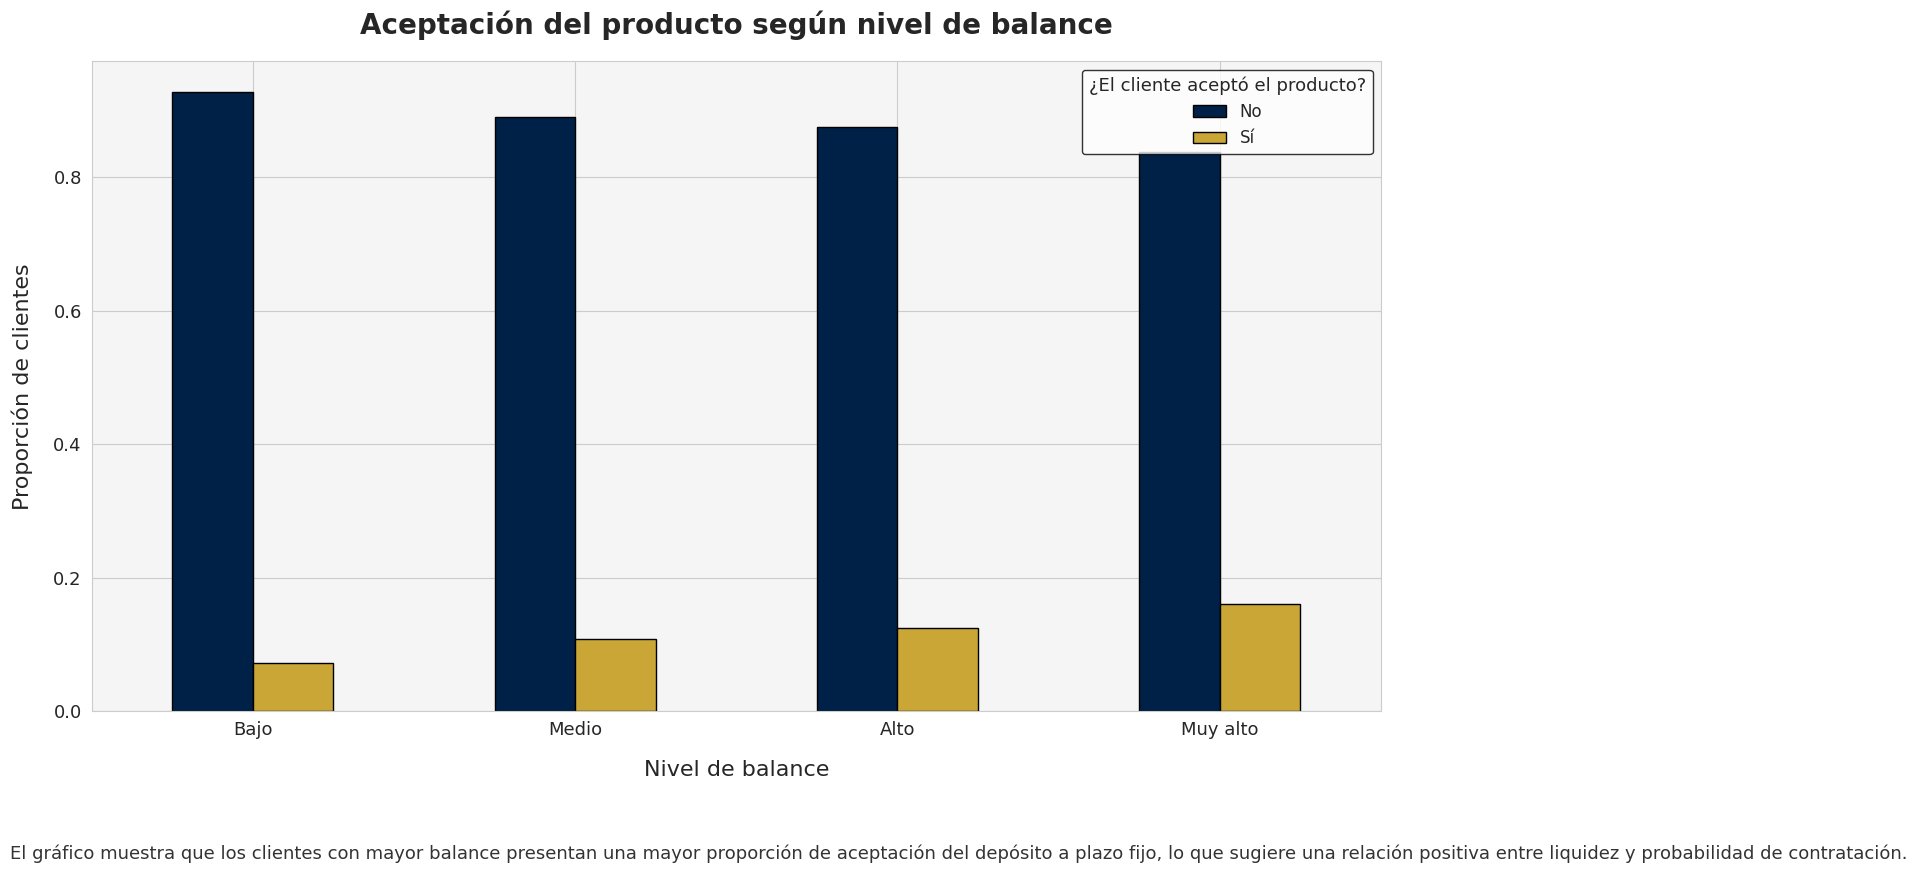

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

#DISCRETIZAR BALANCE
df_entrenamiento['balance_bin'] = pd.qcut(
    df_entrenamiento['balance'],
    q=4,
    labels=['Bajo', 'Medio', 'Alto', 'Muy alto']
)


#TABLA CRUZADA (PROPORCIONES)
#
tabla_cruzada = pd.crosstab(
    df_entrenamiento['balance_bin'],
    df_entrenamiento['y_bin'],
    normalize='index'
)


#COLORES (LOS ORIGINALES)
colores = ['#002147', '#C9A635']  # Azul = No, Dorado = Sí

#GRÁFICA
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#f5f5f5')

tabla_cruzada.plot(
    kind='bar',
    color=colores,
    edgecolor='black',
    ax=ax
)

#TÍTULOS Y ETIQUETAS
ax.set_title(
    'Aceptación del producto según nivel de balance',
    fontsize=20,
    fontweight='bold',
    pad=20
)

ax.set_xlabel(
    'Nivel de balance',
    fontsize=16,
    labelpad=15
)

ax.set_ylabel(
    'Proporción de clientes',
    fontsize=16,
    labelpad=15
)

#EJES
ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=13)

#LEYENDA
ax.legend(
    title='¿El cliente aceptó el producto?',
    labels=['No', 'Sí'],
    title_fontsize=13,
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='black'
)
fig.text(
    0.01, -0.08,
    "El gráfico muestra que los clientes con mayor balance presentan una mayor proporción "
    "de aceptación del depósito a plazo fijo, lo que sugiere una relación positiva entre "
    "liquidez y probabilidad de contratación.",
    fontsize=13,
    color='#333333'
)

plt.tight_layout()
plt.show()


Para analizar la relación entre la liquidez del cliente y la aceptación del producto, el balance fue discretizado en cuatro niveles utilizando cuantiles. Posteriormente, se comparó la proporción de clientes que aceptaron y no aceptaron el depósito en cada nivel, observándose una mayor tasa de aceptación en los clientes con balances más altos.

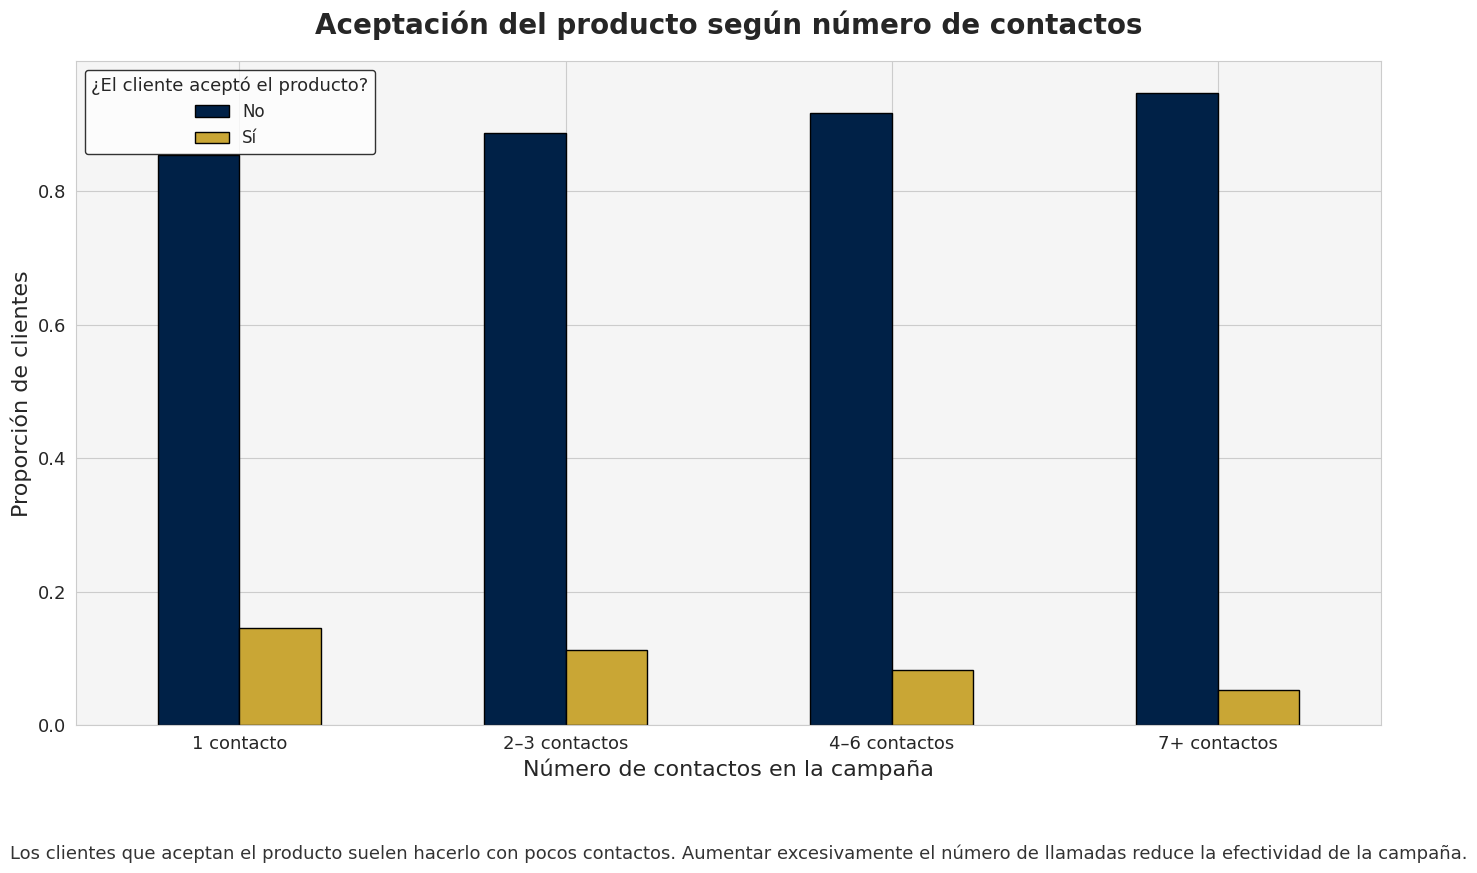

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ESTILO GENERAL
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'DejaVu Sans'

# DISCRETIZAR CAMPAIGN
df_entrenamiento['campaign_bin'] = pd.cut(
    df_entrenamiento['campaign'],
    bins=[0, 1, 3, 6, df_entrenamiento['campaign'].max()],
    labels=['1 contacto', '2–3 contactos', '4–6 contactos', '7+ contactos']
)

# TABLA CRUZADA
tabla_campaign = pd.crosstab(
    df_entrenamiento['campaign_bin'],
    df_entrenamiento['y_bin'],
    normalize='index'
)

# COLORES
colores = ['#002147', '#C9A635']  # Azul = No, Dorado = Sí

# GRÁFICA
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#f5f5f5')

tabla_campaign.plot(
    kind='bar',
    color=colores,
    edgecolor='black',
    ax=ax
)

# TÍTULOS Y ETIQUETAS
ax.set_title(
    'Aceptación del producto según número de contactos',
    fontsize=20,
    fontweight='bold',
    pad=20
)

ax.set_xlabel('Número de contactos en la campaña', fontsize=16)
ax.set_ylabel('Proporción de clientes', fontsize=16)

ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=13)

# LEYENDA
ax.legend(
    title='¿El cliente aceptó el producto?',
    labels=['No', 'Sí'],
    title_fontsize=13,
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

# TEXTO EXPLICATIVO
fig.text(
    0.01, -0.08,
    "Los clientes que aceptan el producto suelen hacerlo con pocos contactos. "
    "Aumentar excesivamente el número de llamadas reduce la efectividad de la campaña.",
    fontsize=13,
    color='#333333'
)

plt.tight_layout()
plt.show()


El análisis muestra que la probabilidad de aceptación del producto es mayor cuando el cliente es contactado pocas veces dentro de una misma campaña. A medida que el número de llamadas aumenta, la proporción de clientes que aceptan el producto disminuye de forma consistente. Este comportamiento sugiere que una estrategia de contacto intensivo no solo pierde efectividad, sino que puede generar rechazo o fatiga en el cliente.

Desde una perspectiva de negocio, este resultado indica que es preferible priorizar la calidad del primer contacto y limitar el número de intentos posteriores, ya que insistir repetidamente incrementa los costos operativos sin mejorar la tasa de conversión. Por lo tanto, la variable campaign resulta relevante tanto desde el análisis exploratorio como para la construcción del modelo predictivo.

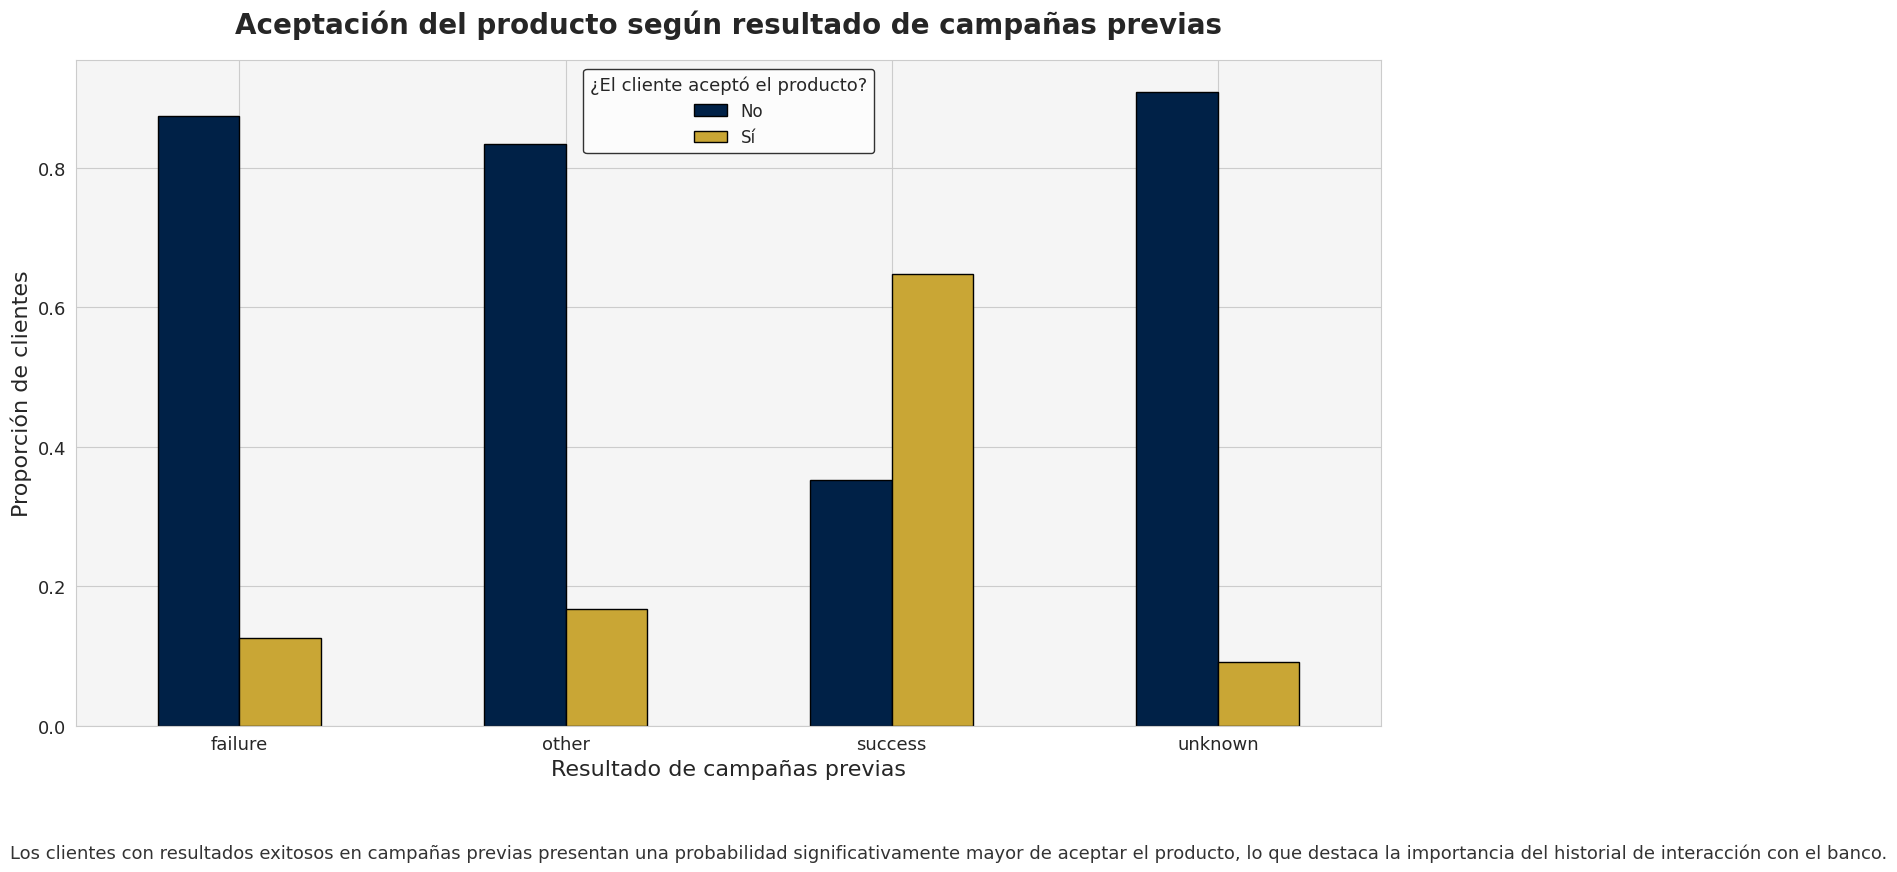

In [75]:
# TABLA CRUZADA
tabla_poutcome = pd.crosstab(
    df_entrenamiento['poutcome'],
    df_entrenamiento['y_bin'],
    normalize='index'
)

# GRÁFICA
fig, ax = plt.subplots(figsize=(14, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('#f5f5f5')

tabla_poutcome.plot(
    kind='bar',
    color=colores,
    edgecolor='black',
    ax=ax
)

# TÍTULOS Y ETIQUETAS
ax.set_title(
    'Aceptación del producto según resultado de campañas previas',
    fontsize=20,
    fontweight='bold',
    pad=20
)

ax.set_xlabel('Resultado de campañas previas', fontsize=16)
ax.set_ylabel('Proporción de clientes', fontsize=16)

ax.tick_params(axis='x', labelsize=13, rotation=0)
ax.tick_params(axis='y', labelsize=13)

# LEYENDA
ax.legend(
    title='¿El cliente aceptó el producto?',
    labels=['No', 'Sí'],
    title_fontsize=13,
    fontsize=12,
    frameon=True,
    facecolor='white',
    edgecolor='black'
)

# TEXTO EXPLICATIVO
fig.text(
    0.01, -0.08,
    "Los clientes con resultados exitosos en campañas previas presentan una probabilidad "
    "significativamente mayor de aceptar el producto, lo que destaca la importancia del "
    "historial de interacción con el banco.",
    fontsize=13,
    color='#333333'
)

plt.tight_layout()
plt.show()


Los resultados evidencian que el historial de interacción del cliente con el banco tiene un impacto significativo en la aceptación del producto. En particular, los clientes que tuvieron un resultado exitoso en campañas anteriores presentan una probabilidad considerablemente mayor de contratar el depósito a plazo fijo, en comparación con aquellos cuyo resultado previo fue negativo o inexistente.

Este hallazgo sugiere que la experiencia pasada del cliente es un factor determinante en su disposición a aceptar nuevos productos financieros. En términos prácticos, la variable poutcome permite identificar clientes con mayor predisposición a la contratación, lo que la convierte en una de las variables más informativas del modelo y en un insumo clave para la segmentación y optimización de futuras campañas de marketing.

##Variables Dummies

In [76]:
df_entrenamiento = pd.get_dummies(
    df_entrenamiento,
    columns=[
        'job',
        'marital',
        'education',
        'default',
        'loan',
        'month',
        'poutcome'
    ],
    drop_first=True
)


In [77]:
#Reemplazamos los valores de False por 0 y de True por 1
df_entrenamiento = df_entrenamiento.replace({False: 0, True: 1})

/tmp/ipython-input-766486781.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_entrenamiento = df_entrenamiento.replace({False: 0, True: 1})


In [78]:

df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 40 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   age                  45211 non-null  int64   
 1   balance              45211 non-null  int64   
 2   campaign             45211 non-null  int64   
 3   pdays                45211 non-null  int64   
 4   y                    45211 non-null  object  
 5   y_bin                45211 non-null  int64   
 6   balance_bin          45211 non-null  category
 7   campaign_bin         45211 non-null  category
 8   job_blue-collar      45211 non-null  int64   
 9   job_entrepreneur     45211 non-null  int64   
 10  job_housemaid        45211 non-null  int64   
 11  job_management       45211 non-null  int64   
 12  job_retired          45211 non-null  int64   
 13  job_self-employed    45211 non-null  int64   
 14  job_services         45211 non-null  int64   
 15  job_student        

In [79]:
variables_objetos= df_entrenamiento.select_dtypes(include=['object']).columns.tolist()
variables_objetos

['y']

In [80]:
# Convertir los valores de las variables numéricas a tipo numérico si no lo son
# El argumento 'errors="coerce"' convierte valores no válidos como texto, nulos, etc. en NaN, para así asegurar que las columnas sean consistentes
for i in variables_objetos:
  df_entrenamiento[i] = df_entrenamiento[i].replace({'$': '', ',': ''}, regex=True)
  df_entrenamiento[i] = pd.to_numeric(df_entrenamiento[i], errors='coerce')

In [81]:

df_entrenamiento.head()

,age,balance,campaign,pdays,y,y_bin,balance_bin,campaign_bin,job_blue-collar,job_entrepreneur,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,NaN,0,Muy alto,1 contacto,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,1,-1,NaN,0,Bajo,1 contacto,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,1,-1,NaN,0,Bajo,1 contacto,0,1,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,1,-1,NaN,0,Muy alto,1 contacto,1,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,1,-1,NaN,0,Bajo,1 contacto,0,0,...,0,0,0,1,0,0,0,0,0,1


In [82]:
#Eliminamos las variables artificiales que usamos para las gráficas y sus análisis
df_entrenamiento.drop(
    columns=['balance_bin', 'campaign_bin', 'y'],
    inplace=True
)


In [83]:
df_entrenamiento

,age,balance,campaign,pdays,y_bin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,1,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,1,-1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,1,-1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,1,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,3,-1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45207,71,1729,2,-1,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
45208,72,5715,5,184,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
45209,57,668,4,-1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [84]:
df_entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 37 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   balance              45211 non-null  int64
 2   campaign             45211 non-null  int64
 3   pdays                45211 non-null  int64
 4   y_bin                45211 non-null  int64
 5   job_blue-collar      45211 non-null  int64
 6   job_entrepreneur     45211 non-null  int64
 7   job_housemaid        45211 non-null  int64
 8   job_management       45211 non-null  int64
 9   job_retired          45211 non-null  int64
 10  job_self-employed    45211 non-null  int64
 11  job_services         45211 non-null  int64
 12  job_student          45211 non-null  int64
 13  job_technician       45211 non-null  int64
 14  job_unemployed       45211 non-null  int64
 15  job_unknown          45211 non-null  int64
 16  marital_married      4

##Valores Nulos

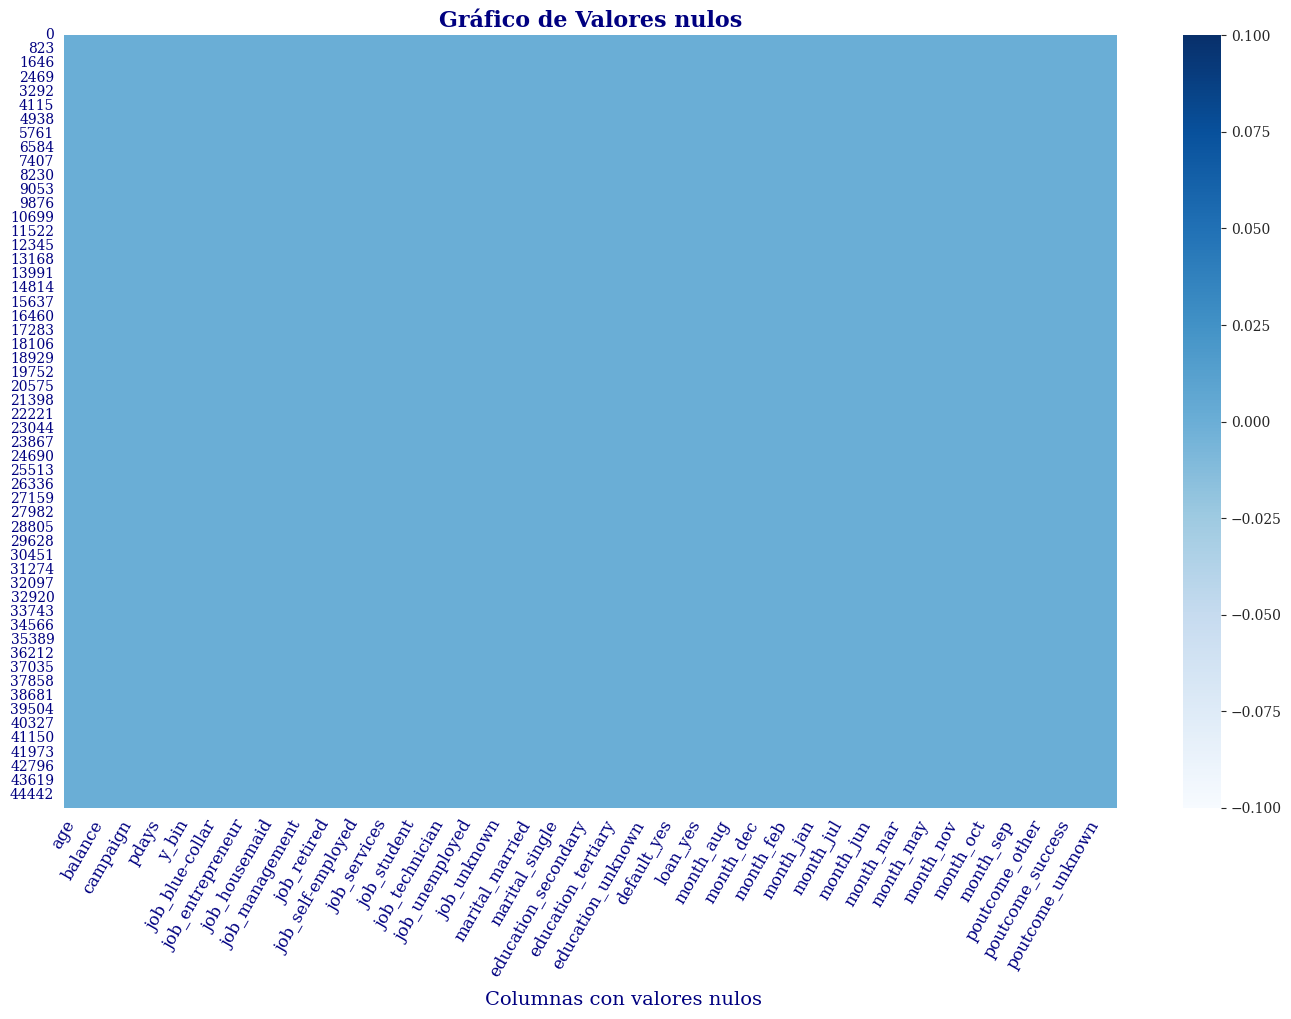

In [85]:
#El siguiente gráfico nos permite visualizar la cantidad de valores nulos que hay en nuestro dataset
# facecolor--> color  de fondo
plt.figure(figsize=(14,10), facecolor = 'white')
#Tipo de letra para el gráfico
plt.rcParams['font.family'] = 'DejaVu Serif'
#Grafico para ver la proporción de valores nulos
sns.heatmap(df_entrenamiento.isnull(), cmap = 'Blues')

# Agregamos el título
#fontweight='bold'-->Negritas
plt.title('Gráfico de Valores nulos',
          fontsize=16, color ='navy', fontweight = 'bold')
#Agregamos las etiquetas de los valores del eje X
plt.xticks(fontsize=12, color='navy',rotation=60, ha='right')
plt.yticks(fontsize=10, color='navy')
#Agregamos la interpretacion de la grafica
plt.figtext(0.35, -0.01, "Columnas con valores nulos",
            fontsize = 14, color='navy')
#Mostramos el gráfico
plt.tight_layout()
plt.show()


In [87]:
# Porcentaje de valores nulos por columna (variables numéricas)
df_entrenamiento[
    ['age', 'balance', 'campaign', 'pdays']
].isnull().mean() * 100


,0
age,0.0
balance,0.0
campaign,0.0
pdays,0.0


No hay nulos

##Correlación

In [88]:

# Matriz de correlación
df_entrenamiento.corr()

,age,balance,campaign,pdays,y_bin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
age,1.000000,0.097783,0.004760,-0.023758,0.025155,-0.044002,0.021792,0.086650,-0.023571,0.447378,...,0.002902,0.051768,0.019499,-0.127431,0.032775,0.060116,0.032418,-0.022967,0.035526,-0.000816
balance,0.097783,1.000000,-0.014578,0.003435,0.052838,-0.048757,0.009642,0.001661,0.067797,0.046900,...,-0.064402,0.029566,0.023196,-0.071121,0.117254,0.040198,0.021922,0.008466,0.035240,-0.030271
campaign,0.004760,-0.014578,1.000000,-0.088628,-0.073172,0.008986,0.002128,0.003097,0.016686,-0.030913,...,0.104148,0.043893,-0.018612,-0.067551,-0.084697,-0.051031,-0.036718,-0.020107,-0.057486,0.107965
pdays,-0.023758,0.003435,-0.088628,1.000000,0.103621,0.020063,-0.014203,-0.031350,-0.007871,-0.006315,...,-0.136274,-0.113476,0.032002,0.079029,0.007892,0.056814,0.084427,0.389791,0.228539,-0.869962
y_bin,0.025155,0.052838,-0.073172,0.103621,1.000000,-0.072083,-0.019662,-0.015195,0.032919,0.079245,...,-0.034382,-0.016805,0.129456,-0.102500,-0.014937,0.128531,0.123185,0.031955,0.306788,-0.167051
job_blue-collar,-0.044002,-0.048757,0.008986,0.020063,-0.072083,1.000000,-0.096585,-0.087951,-0.269376,-0.120251,...,-0.013203,0.021727,-0.041441,0.165448,-0.048027,-0.042410,-0.044816,0.001342,-0.053074,0.022194
job_entrepreneur,0.021792,0.009642,0.002128,-0.014203,-0.019662,-0.096585,1.000000,-0.030969,-0.094850,-0.042342,...,0.025949,0.015497,-0.016615,-0.009908,0.051017,-0.012012,-0.007769,-0.013506,-0.019111,0.014901
job_housemaid,0.086650,0.001661,0.003097,-0.031350,-0.015195,-0.087951,-0.030969,1.000000,-0.086372,-0.038557,...,0.034992,0.052663,-0.000110,-0.066673,-0.013343,0.006155,-0.002265,-0.016769,-0.009375,0.026059
job_management,-0.023571,0.067797,0.016686,-0.007871,0.032919,-0.269376,-0.094850,-0.086372,1.000000,-0.118091,...,-0.013827,-0.032403,0.023532,-0.084114,0.051012,0.009704,0.023154,0.002223,0.021453,-0.013755
job_retired,0.447378,0.046900,-0.030913,-0.006315,0.079245,-0.120251,-0.042342,-0.038557,-0.118091,1.000000,...,-0.001770,0.011167,0.041801,-0.073902,-0.022146,0.077666,0.061337,-0.004691,0.055485,-0.019368


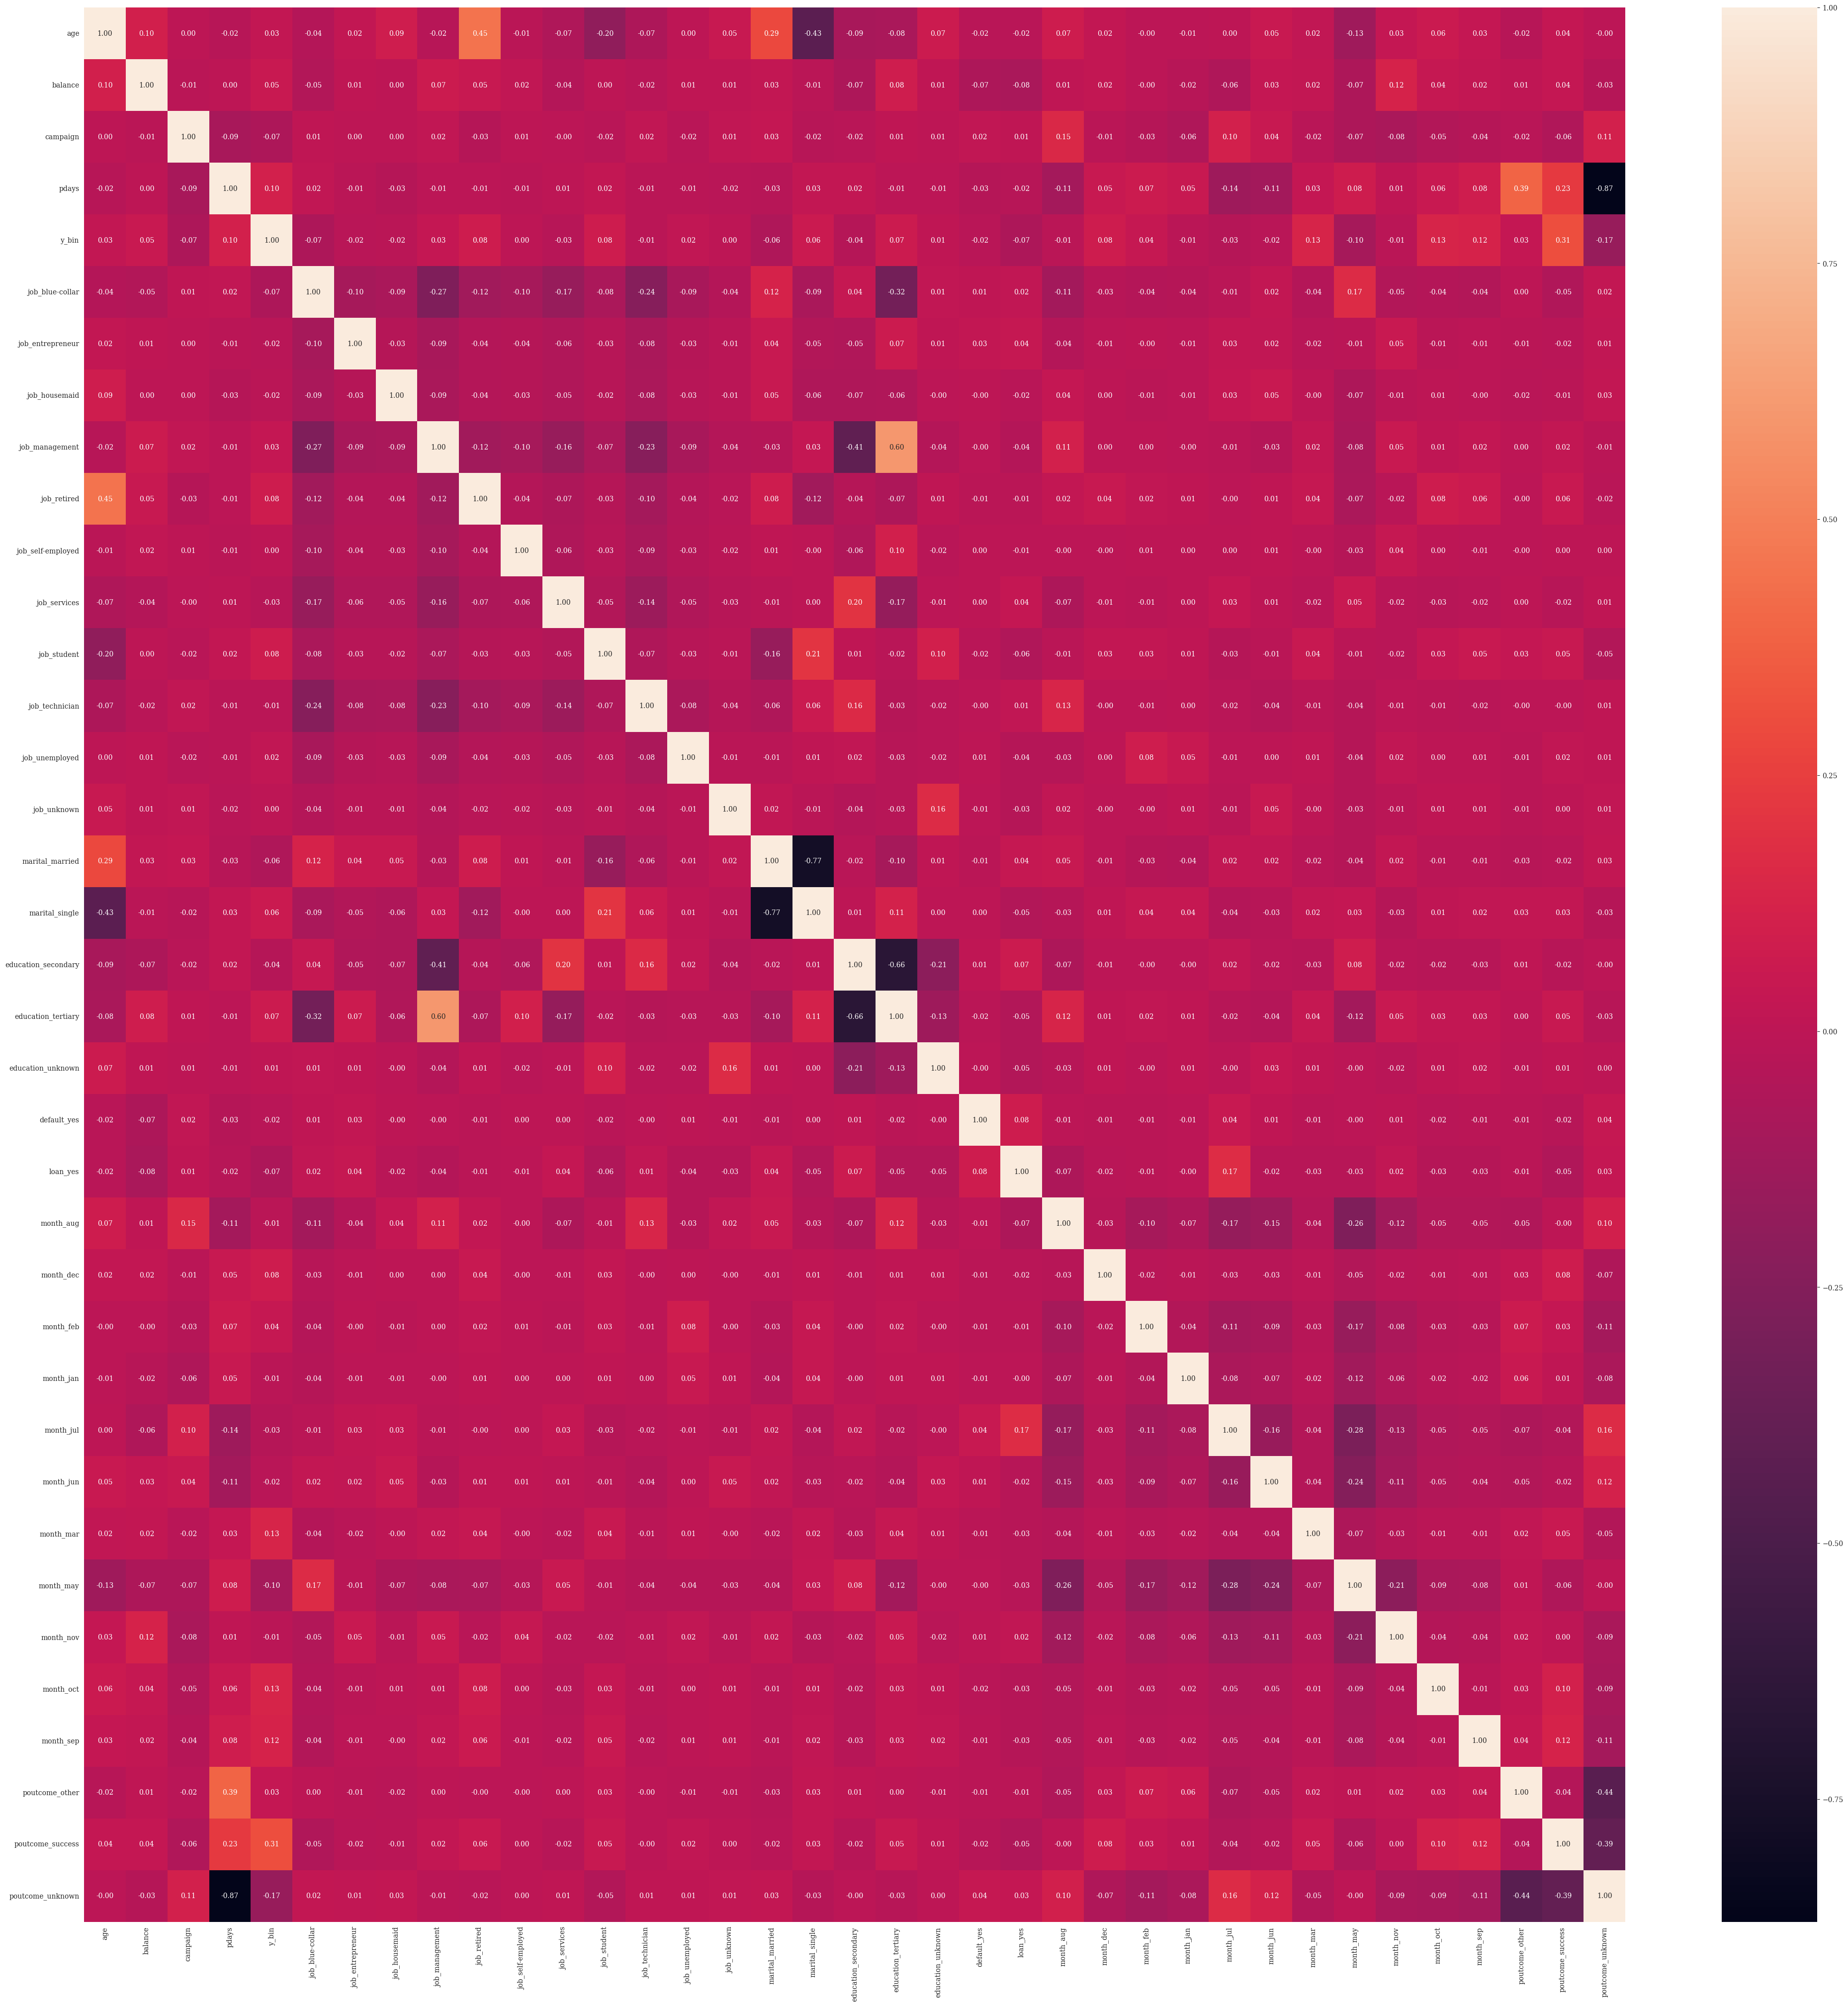

In [89]:

# Grafico de correlación
plt.figure(figsize = (50, 50))
sns.heatmap(df_entrenamiento.corr(), annot = True, fmt = ".2f")
plt.show()

In [91]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_VIF = df_entrenamiento.drop(columns=['y_bin'])
df_VIF

,age,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,1,-1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
1,44,29,1,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
2,33,2,1,-1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,47,1506,1,-1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,33,1,1,-1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,825,3,-1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
45207,71,1729,2,-1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
45208,72,5715,5,184,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
45209,57,668,4,-1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [92]:
vif_data = pd.DataFrame()
vif_data["feature"] = df_VIF.columns
vif_data["VIF"] = [variance_inflation_factor(df_VIF.values, i) for i in range(df_VIF.shape[1])]
vif_data

,feature,VIF
0,age,18.540603
1,balance,1.261354
2,campaign,1.905146
3,pdays,3.858830
4,job_blue-collar,2.922448
5,job_entrepreneur,1.331645
6,job_housemaid,1.293590
7,job_management,3.721616
8,job_retired,1.785415
9,job_self-employed,1.350790


In [93]:
#Clasificamos las variables según su VIF
vif_menor_5 = vif_data[vif_data["VIF"] < 5]
vif_entre_5_10 = vif_data[(vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10)]
vif_mayor_10 = vif_data[vif_data["VIF"] > 10]


In [94]:
print("Variables con VIF < 5:")
print(vif_menor_5)

print("\nVariables con 5 <= VIF <= 10:")
print(vif_entre_5_10)

print("\nVariables con VIF > 10:")
print(vif_mayor_10)

Variables con VIF < 5:
                feature       VIF
1               balance  1.261354
2              campaign  1.905146
3                 pdays  3.858830
4       job_blue-collar  2.922448
5      job_entrepreneur  1.331645
6         job_housemaid  1.293590
7        job_management  3.721616
8           job_retired  1.785415
9     job_self-employed  1.350790
10         job_services  1.743236
11          job_student  1.226887
12       job_technician  2.438454
13       job_unemployed  1.259586
14          job_unknown  1.094806
16       marital_single  3.377722
17  education_secondary  4.663883
18   education_tertiary  4.362054
19    education_unknown  1.335078
20          default_yes  1.033174
21             loan_yes  1.259095
22            month_aug  3.179421
23            month_dec  1.074387
24            month_feb  1.786789
25            month_jan  1.412144
26            month_jul  3.324603
27            month_jun  2.744042
28            month_mar  1.153821
30            month_nov  

In [95]:
# Eliminamos las variables
columnas_a_eliminar = [
    'age',
    'poutcome_unknown'
]
df_entrenamiento = df_entrenamiento.drop(columnas_a_eliminar, axis=1)
df_entrenamiento


,balance,campaign,pdays,y_bin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,2143,1,-1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,29,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,1,-1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1506,1,-1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,-1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,825,3,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
45207,1729,2,-1,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
45208,5715,5,184,1,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
45209,668,4,-1,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Con base en el análisis del Factor de Inflación de la Varianza (VIF), se identificaron variables con multicolinealidad severa. En particular, la variable age y la categoría poutcome_unknown presentaron valores de VIF superiores a 10, por lo que fueron excluidas del modelo final para mejorar la estabilidad de los coeficientes y evitar distorsiones en la interpretación de la regresión logística.

In [96]:
df_entrenamiento = df_entrenamiento.astype(float)

In [97]:
df_entrenamiento

,balance,campaign,pdays,y_bin,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,2143.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,29.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,-1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1506.0,1.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,825.0,3.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45207,1729.0,2.0,-1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
45208,5715.0,5.0,184.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
45209,668.0,4.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


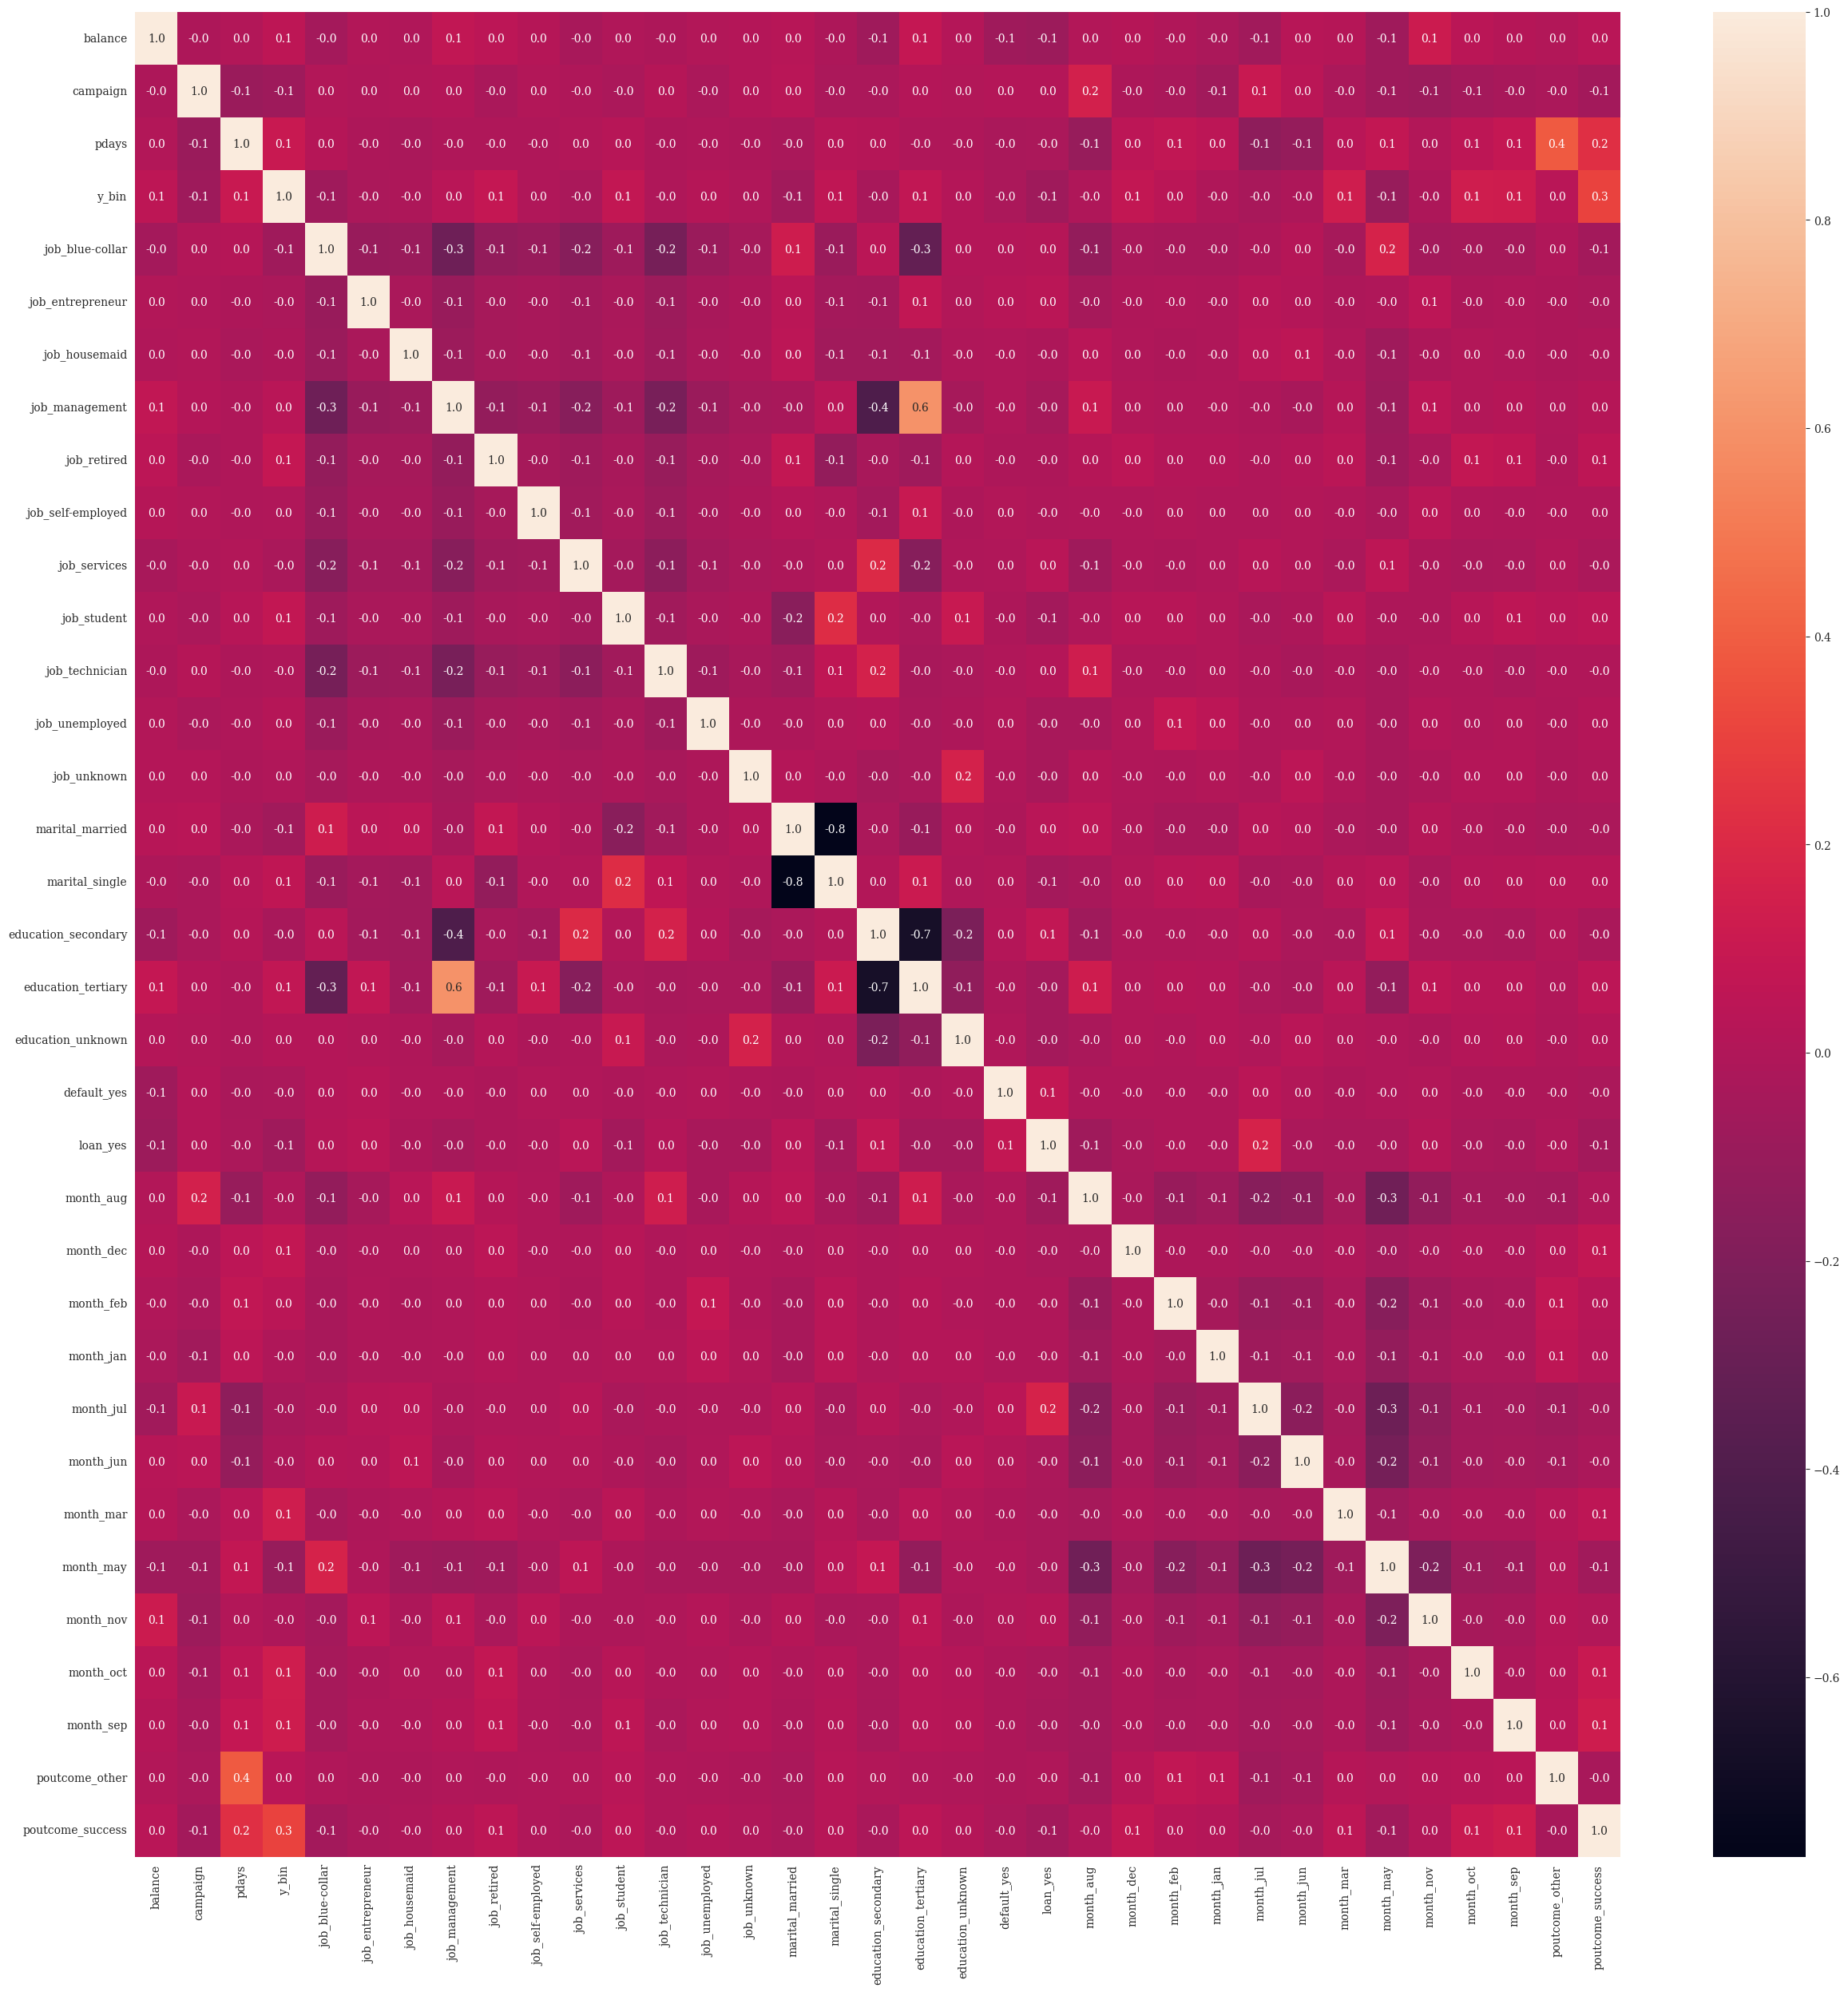

In [101]:
# Grafico de correlación
plt.figure(figsize = (30, 30))
sns.heatmap(df_entrenamiento.corr(), annot = True, fmt = ".1f")
plt.show()

## Regresión Logística

###Oversampling

In [103]:
X = df_entrenamiento.loc[:, df_entrenamiento.columns != "y_bin"]
Y = df_entrenamiento["y_bin"]

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

os = SMOTE(random_state=0)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
columns = X_train.columns

In [104]:
print(X.shape, Y.shape)

(45211, 34) (45211,)


In [105]:
print(X_train.shape, Y_train.shape)

(31647, 34) (31647,)


In [106]:
os_data_X, os_data_Y = os.fit_resample(X_train, Y_train)
os_data_X = pd.DataFrame(data = os_data_X, columns = columns)
os_data_Y = pd.DataFrame(data = os_data_Y, columns = ["y_bin"])

In [107]:
os_data_X.shape

(55906, 34)

In [108]:
os_data_Y.value_counts()

,count
y_bin,
0.0,27953
1.0,27953


In [109]:
df_entrenamiento_variables = df_entrenamiento.columns.values.tolist()
Y = ["y_bin"]
X = [i for i in df_entrenamiento_variables if i not in Y]


In [110]:
X = os_data_X
Y = os_data_Y

In [111]:
import statsmodels.api as sm

In [112]:
# Se agregó manualmente un término constante a la matriz de variables independientes utilizando
# sm.add_constant(X) con el objetivo de incluir un intercepto en el modelo de regresión logística.
# La presencia del intercepto es fundamental, ya que permite que el modelo estime una probabilidad
# base del evento de interés cuando todas las variables predictoras toman el valor de cero.
X_m = sm.add_constant(X)


In [113]:
X_m.corr()

,const,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
balance,NaN,1.000000,-0.007497,0.002194,-0.070204,0.010914,-0.004637,0.063019,0.079827,0.038870,...,-0.023160,-0.074612,0.019056,0.040694,-0.080408,0.099268,0.048364,0.027205,0.026021,0.044359
campaign,NaN,-0.007497,1.000000,-0.096172,0.029313,0.023019,0.014385,0.007550,-0.041002,0.005334,...,-0.053158,0.118855,0.046434,-0.041557,-0.028878,-0.074446,-0.068345,-0.061069,-0.016398,-0.096639
pdays,NaN,0.002194,-0.096172,1.000000,-0.013890,-0.025414,-0.022856,0.032340,0.006695,-0.018922,...,0.035543,-0.109101,-0.107016,0.031190,0.039218,-0.002030,0.085741,0.087535,0.371529,0.374753
job_blue-collar,NaN,-0.070204,0.029313,-0.013890,1.000000,-0.080592,-0.073707,-0.262104,-0.133336,-0.093512,...,-0.039194,0.012750,0.027321,-0.060039,0.183826,-0.042759,-0.061134,-0.059542,-0.009475,-0.091431
job_entrepreneur,NaN,0.010914,0.023019,-0.025414,-0.080592,1.000000,-0.024953,-0.092542,-0.048515,-0.032547,...,-0.001223,0.044453,0.004792,-0.016008,-0.001254,0.044513,-0.024194,-0.006818,-0.016060,-0.046852
job_housemaid,NaN,-0.004637,0.014385,-0.022856,-0.073707,-0.024953,1.000000,-0.084138,-0.039787,-0.029670,...,-0.004743,0.031483,0.034359,0.006423,-0.051290,-0.009817,0.004928,-0.011893,-0.010813,-0.011803
job_management,NaN,0.063019,0.007550,0.032340,-0.262104,-0.092542,-0.084138,1.000000,-0.134710,-0.103209,...,-0.019427,-0.028880,-0.026587,0.035630,-0.084876,0.033801,0.034483,0.050132,0.022656,0.058590
job_retired,NaN,0.079827,-0.041002,0.006695,-0.133336,-0.048515,-0.039787,-0.134710,1.000000,-0.051444,...,0.012685,-0.017427,-0.002302,0.074284,-0.092638,-0.014859,0.055197,0.062456,0.004456,0.075197
job_self-employed,NaN,0.038870,0.005334,-0.018922,-0.093512,-0.032547,-0.029670,-0.103209,-0.051444,1.000000,...,0.007586,0.003844,0.023260,0.000676,-0.027874,0.036202,-0.013582,-0.010828,0.008281,-0.009435


In [114]:
log_reg = sm.Logit(Y, X_m).fit()

Optimization terminated successfully.
         Current function value: 0.566879
         Iterations 7


In [115]:
print(log_reg.summary2())

                           Results: Logit
Model:               Logit             Method:            MLE       
Dependent Variable:  y_bin             Pseudo R-squared:  0.182     
Date:                2025-12-13 16:02  AIC:               63453.8850
No. Observations:    55906             BIC:               63766.4850
Df Model:            34                Log-Likelihood:    -31692.   
Df Residuals:        55871             LL-Null:           -38751.   
Converged:           1.0000            LLR p-value:       0.0000    
No. Iterations:      7.0000            Scale:             1.0000    
--------------------------------------------------------------------
                     Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                0.7617   0.0635  11.9962 0.0000  0.6372  0.8861
balance              0.0000   0.0000   8.5450 0.0000  0.0000  0.0000
campaign            -0.1090   0.0050 -21.8273 0.0000 -0.1188 

In [116]:
X.head()

,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,1021.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,196.0,2.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,159.0,2.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1880.0,6.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,647.0,6.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [117]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 45)

In [118]:
X_train

,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
2705,-199.000000,12.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
49319,1377.000000,2.0,-1.0,0.000000,0.0,0.0,0.282306,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.717694,0.000000,0.0,0.000000,0.0,0.0
11960,1115.000000,1.0,-1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
27216,65.000000,2.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0
0,1021.000000,1.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32469,4536.905614,1.0,-1.0,0.698129,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.698129,0.0,0.301871,0.0,0.0
16317,159.000000,2.0,262.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
12895,4209.000000,6.0,-1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
6012,281.000000,1.0,-1.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0


In [119]:
X_train.shape

(39134, 34)

In [120]:
X_test

,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
52836,480.044926,1.044926,-1.0,0.022463,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.022463,0.000000,0.000000,0.000000,0.0,0.000000,0.977537,0.0,0.0
46310,1807.000000,1.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.809132,0.0,0.000000,...,0.0,0.000000,0.000000,0.190868,0.000000,0.0,0.809132,0.000000,0.0,0.0
35560,-404.829940,1.468092,-1.0,0.468092,0.000000,0.000000,0.000000,0.000000,0.0,0.531908,...,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0
47790,669.869041,1.000000,-1.0,0.000000,0.934521,0.000000,0.000000,0.065479,0.0,0.000000,...,0.0,0.065479,0.000000,0.000000,0.934521,0.0,0.000000,0.000000,0.0,0.0
50926,3158.888884,2.000000,-1.0,0.000000,0.000000,0.000000,0.444442,0.000000,0.0,0.000000,...,0.0,0.000000,0.555558,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27919,172.000000,3.000000,-1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,...,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0
41725,2922.371249,1.447604,-1.0,0.000000,0.000000,0.447604,0.000000,0.552396,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.552396,0.000000,0.0,0.0
36387,-308.887724,1.887724,-1.0,0.112276,0.000000,0.000000,0.000000,0.887724,0.0,0.000000,...,0.0,0.000000,0.887724,0.000000,0.112276,0.0,0.000000,0.000000,0.0,0.0
40410,1441.123966,1.938017,-1.0,0.000000,0.000000,0.000000,0.938017,0.061983,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [121]:
X_test.shape

(16772, 34)

In [122]:
Y_test

,y_bin
52836,1.0
46310,1.0
35560,1.0
47790,1.0
50926,1.0
...,...
27919,0.0
41725,1.0
36387,1.0
40410,1.0


In [123]:
Y_train

,y_bin
2705,0.0
49319,1.0
11960,1.0
27216,0.0
0,0.0
...,...
32469,1.0
16317,0.0
12895,0.0
6012,0.0


In [124]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train,Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [125]:
predicciones = model.predict(X_test)
predicciones

array([1., 1., 0., ..., 1., 1., 0.])

In [126]:
model.predict_proba(X_test)[:,1]

array([0.86296083, 0.87784187, 0.25615135, ..., 0.66312666, 0.62652521,
       0.48368878])

In [127]:
predicciones.shape

(16772,)

In [128]:
Y_test

,y_bin
52836,1.0
46310,1.0
35560,1.0
47790,1.0
50926,1.0
...,...
27919,0.0
41725,1.0
36387,1.0
40410,1.0


In [129]:
Y_test.shape

(16772, 1)

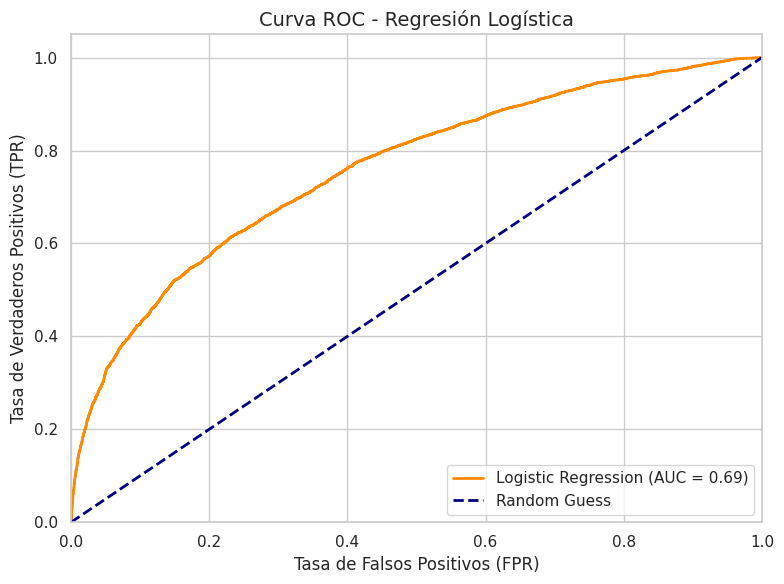

In [130]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Calcular AUC y curva ROC
logit_roc_auc = roc_auc_score(Y_test, model.predict(X_test))
fpr_lr, tpr_lr, thresholds = roc_curve(Y_test, model.predict_proba(X_test)[:,1])

# Estilo Seaborn
sns.set(style="whitegrid")

# Crear figura
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2,
         label='Logistic Regression (AUC = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')

# Límites y etiquetas
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - Regresión Logística', fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()

# Guardar y mostrar
plt.savefig('Log_ROC_Improved.png')
plt.show()


La curva ROC obtenida para el modelo de Regresión Logística muestra un área bajo la curva (AUC) de 0.69, lo que indica una buena capacidad del modelo para discriminar entre clases positivas y negativas. Cuanto más se acerque esta curva a la esquina superior izquierda, mejor será el desempeño del modelo. En este caso, la curva se aleja visiblemente de la diagonal (representando una clasificación aleatoria), lo que sugiere que el modelo tiene un rendimiento superior al azar en la tarea de clasificación.

In [131]:
fpr_lr

array([0.        , 0.        , 0.        , ..., 0.99846318, 0.99846318,
       1.        ])

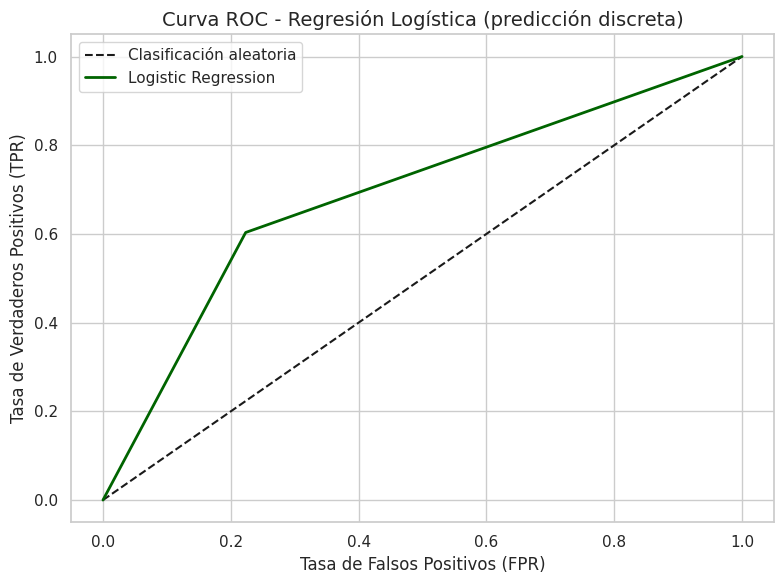

In [132]:
# Obtener curva ROC a partir de predicciones discretas (0 o 1)
fpr_lr, tpr_lr, _ = roc_curve(Y_test, predicciones)

# Estilo Seaborn
sns.set(style="whitegrid")

# Crear figura
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--', label='Clasificación aleatoria')
plt.plot(fpr_lr, tpr_lr, color='darkgreen', lw=2, label='Logistic Regression')
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=12)
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=12)
plt.title('Curva ROC - Regresión Logística (predicción discreta)', fontsize=14)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

La curva ROC construida a partir de las predicciones discretas (clases 0 y 1) del modelo de Regresión Logística muestra la relación entre la tasa de verdaderos positivos y la de falsos positivos. Aunque este enfoque puede limitar la suavidad de la curva (ya que no considera las probabilidades), la forma de la curva sigue indicando una capacidad razonable del modelo para distinguir entre clases. Si la curva se encuentra por encima de la diagonal aleatoria, como en este caso, el modelo tiene un rendimiento mejor que una clasificación al azar.

In [133]:
fpr_lr

array([0.        , 0.22331245, 1.        ])

In [134]:
from sklearn.metrics import classification_report

In [135]:
print(classification_report(Y_test,predicciones))

              precision    recall  f1-score   support

         0.0       0.67      0.78      0.72      8459
         1.0       0.73      0.60      0.66      8313

    accuracy                           0.69     16772
   macro avg       0.70      0.69      0.69     16772
weighted avg       0.70      0.69      0.69     16772



El modelo de Regresión Logística alcanzó una exactitud global del 69%, lo que indica una capacidad razonable para clasificar correctamente a los clientes que aceptan y no aceptan el producto. Para la clase 1.0 (clientes que aceptaron el producto), el modelo obtuvo un recall de 0.60, lo que significa que identifica correctamente el 60% de los clientes que efectivamente contrataron el depósito a plazo fijo. Este resultado sugiere que, aunque el modelo es conservador al predecir la aceptación, aún deja escapar una proporción de clientes potenciales (falsos negativos).

Por otro lado, la clase 0.0 (clientes que no aceptaron el producto) presenta un recall de 0.78, indicando que el modelo es más efectivo al identificar a los clientes que no contratarán el producto, lo cual resulta útil para evitar esfuerzos de contacto innecesarios. En términos de precisión, el modelo alcanza un valor de 0.73 para la clase positiva (1.0), lo que implica que cuando el modelo predice que un cliente aceptará el producto, acierta en el 73% de los casos.

El equilibrio entre precisión y recall se refleja en los valores de F1-score, con 0.72 para la clase 0.0 y 0.66 para la clase 1.0, lo que evidencia un desempeño ligeramente superior en la identificación de clientes que no aceptan el producto. En conjunto, estos resultados sugieren que el modelo es adecuado como herramienta de apoyo para la toma de decisiones, especialmente para la segmentación y priorización de clientes en campañas de marketing, aunque existe margen de mejora en la detección de clientes con alta probabilidad de aceptación.

In [136]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test,predicciones)

array([[6570, 1889],
       [3298, 5015]])

In [137]:
import statsmodels.api as sm
import pandas as pd
Y_test.head()

,y_bin
52836,1.0
46310,1.0
35560,1.0
47790,1.0
50926,1.0


In [138]:
X_test.head()

,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
52836,480.044926,1.044926,-1.0,0.022463,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.022463,0.000000,0.000000,0.000000,0.0,0.000000,0.977537,0.0,0.0
46310,1807.000000,1.000000,-1.0,0.000000,0.000000,0.0,0.000000,0.809132,0.0,0.000000,...,0.0,0.000000,0.000000,0.190868,0.000000,0.0,0.809132,0.000000,0.0,0.0
35560,-404.829940,1.468092,-1.0,0.468092,0.000000,0.0,0.000000,0.000000,0.0,0.531908,...,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0
47790,669.869041,1.000000,-1.0,0.000000,0.934521,0.0,0.000000,0.065479,0.0,0.000000,...,0.0,0.065479,0.000000,0.000000,0.934521,0.0,0.000000,0.000000,0.0,0.0
50926,3158.888884,2.000000,-1.0,0.000000,0.000000,0.0,0.444442,0.000000,0.0,0.000000,...,0.0,0.000000,0.555558,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0


In [139]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16772 entries, 52836 to 19107
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   balance              16772 non-null  float64
 1   campaign             16772 non-null  float64
 2   pdays                16772 non-null  float64
 3   job_blue-collar      16772 non-null  float64
 4   job_entrepreneur     16772 non-null  float64
 5   job_housemaid        16772 non-null  float64
 6   job_management       16772 non-null  float64
 7   job_retired          16772 non-null  float64
 8   job_self-employed    16772 non-null  float64
 9   job_services         16772 non-null  float64
 10  job_student          16772 non-null  float64
 11  job_technician       16772 non-null  float64
 12  job_unemployed       16772 non-null  float64
 13  job_unknown          16772 non-null  float64
 14  marital_married      16772 non-null  float64
 15  marital_single       16772 non-null  

In [140]:
(X_train.nunique() == 1)

,0
balance,False
campaign,False
pdays,False
job_blue-collar,False
job_entrepreneur,False
job_housemaid,False
job_management,False
job_retired,False
job_self-employed,False
job_services,False


In [141]:
# Eliminar columnas constantes (donde la varianza es 0)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0)  # Elimina columnas constantes
X_train = pd.DataFrame(selector.fit_transform(X_train), columns=X_train.columns[selector.get_support()])
# Eliminar columnas duplicadas
X_train = X_train.loc[:, ~X_train.T.duplicated()]
X_train = X_train.reset_index(drop=True)
Y_train = Y_train.reset_index(drop=True)

In [142]:
X_train

,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,-199.000000,12.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,1377.000000,2.0,-1.0,0.000000,0.0,0.0,0.282306,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.717694,0.000000,0.0,0.000000,0.0,0.0
2,1115.000000,1.0,-1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,65.000000,2.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0
4,1021.000000,1.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39129,4536.905614,1.0,-1.0,0.698129,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.698129,0.0,0.301871,0.0,0.0
39130,159.000000,2.0,262.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39131,4209.000000,6.0,-1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39132,281.000000,1.0,-1.0,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0


In [143]:
X_train = sm.add_constant(X_train, has_constant='add')
X_train

,const,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,1.0,-199.000000,12.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,1.0,1377.000000,2.0,-1.0,0.000000,0.0,0.0,0.282306,0.0,0.0,...,0.0,0.0,0.0,0.0,0.717694,0.000000,0.0,0.000000,0.0,0.0
2,1.0,1115.000000,1.0,-1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,1.0,65.000000,2.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0
4,1.0,1021.000000,1.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39129,1.0,4536.905614,1.0,-1.0,0.698129,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.698129,0.0,0.301871,0.0,0.0
39130,1.0,159.000000,2.0,262.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39131,1.0,4209.000000,6.0,-1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39132,1.0,281.000000,1.0,-1.0,0.000000,0.0,1.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0


In [144]:
log_reg = sm.Logit(Y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.566226
         Iterations 7


In [145]:
X_train

,const,balance,campaign,pdays,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,...,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success
0,1.0,-199.000000,12.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,1.0,1377.000000,2.0,-1.0,0.000000,0.0,0.0,0.282306,0.0,0.0,...,0.0,0.0,0.0,0.0,0.717694,0.000000,0.0,0.000000,0.0,0.0
2,1.0,1115.000000,1.0,-1.0,0.000000,0.0,0.0,0.000000,1.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
3,1.0,65.000000,2.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0
4,1.0,1021.000000,1.0,-1.0,0.000000,0.0,0.0,1.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39129,1.0,4536.905614,1.0,-1.0,0.698129,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.698129,0.0,0.301871,0.0,0.0
39130,1.0,159.000000,2.0,262.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39131,1.0,4209.000000,6.0,-1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
39132,1.0,281.000000,1.0,-1.0,0.000000,0.0,1.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.000000,0.000000,0.0,0.000000,0.0,0.0


In [146]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  y_bin   No. Observations:                39134
Model:                          Logit   Df Residuals:                    39099
Method:                           MLE   Df Model:                           34
Date:                Sat, 13 Dec 2025   Pseudo R-squ.:                  0.1831
Time:                        16:11:24   Log-Likelihood:                -22159.
converged:                       True   LL-Null:                       -27125.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.7749      0.076     10.229      0.000       0.626       0.923
balance              3.292e-05   4.05e-06      8.134      0.000     2.5e-05    4.08e-05
campaign        

## Análisis del modelo de Regresión Logística

El modelo de Regresión Logística tiene como variable dependiente y_bin, que indica la probabilidad de que un cliente acepte el depósito a plazo fijo ofrecido por el banco. El modelo fue ajustado con 39,134 observaciones y presenta un Pseudo R-cuadrado de 0.1831, lo que sugiere que aproximadamente el 18.31% de la variabilidad en la decisión de aceptación es explicada por las variables incluidas en el modelo. Si bien este valor no es elevado, es consistente con modelos de comportamiento del cliente, donde la decisión de contratación depende de múltiples factores no observables.

El valor de LLR p-value = 0.000 indica que el modelo es globalmente significativo, es decir, que el conjunto de variables explicativas mejora significativamente el ajuste frente a un modelo sin predictores.

##Variables significativas y su interpretación
###Variables numéricas

 - Balance (coef = 3.29e-05, p < 0.001):
Un mayor balance en la cuenta del cliente incrementa la probabilidad de aceptación del producto. Aunque el coeficiente es pequeño, su efecto acumulado es relevante, lo que indica que clientes con mayor liquidez tienen mayor disposición a contratar productos de ahorro.

 - Campaign (coef = -0.1069, p < 0.001):
El número de contactos durante la campaña tiene un efecto negativo sobre la probabilidad de aceptación. Cada contacto adicional reduce la probabilidad de contratación, lo que sugiere un efecto de saturación o fatiga del cliente ante múltiples llamadas.

 - Pdays (coef = -0.0003, p = 0.016):
Un mayor número de días desde el último contacto previo se asocia con una menor probabilidad de aceptación, indicando que el interés del cliente disminuye conforme pasa más tiempo sin interacción con el banco.

 - Ocupación (job)

El grupo de referencia corresponde a la ocupación que no aparece explícitamente en el modelo (por ejemplo, admin.).

Job_retired (coef = 0.5667, p < 0.001) y job_student (coef = 0.5290, p < 0.001):
Los clientes retirados y estudiantes presentan una mayor probabilidad de aceptar el producto, posiblemente debido a una mayor preferencia por productos de ahorro o menor aversión al compromiso financiero.

Job_blue-collar, job_entrepreneur, job_housemaid, job_management, job_services y job_technician (coeficientes negativos, p < 0.05):
Estas ocupaciones muestran una menor propensión a aceptar el producto en comparación con el grupo de referencia, lo que podría estar relacionado con restricciones de ingreso, estabilidad laboral o preferencias financieras distintas.

Job_self-employed y job_unknown:
No resultaron estadísticamente significativas, por lo que su efecto sobre la aceptación no es concluyente.

 - Estado civil (marital)

Marital_married (coef = -0.2717, p < 0.001):
Estar casado reduce la probabilidad de aceptación del producto, posiblemente debido a una mayor carga financiera o decisiones financieras compartidas.

Marital_single (coef = 0.1719, p < 0.001):
Los clientes solteros presentan mayor propensión a aceptar el producto en comparación con el grupo de referencia.

 - Nivel educativo (education)

Education_tertiary (coef = 0.3362, p < 0.001):
Un mayor nivel educativo incrementa la probabilidad de aceptación, lo que puede reflejar una mejor comprensión de los beneficios del producto financiero.

Education_secondary y education_unknown:
No resultaron estadísticamente significativas al nivel del 5%.

 - Situación crediticia

Loan_yes (coef = -0.5268, p < 0.001):
Tener un crédito personal activo reduce significativamente la probabilidad de aceptación, lo cual es consistente con una menor capacidad de ahorro debido a compromisos financieros previos.

Default_yes:
No resultó significativa, aunque el signo negativo sugiere una menor propensión a contratar el producto.

 - Mes de contacto (month)

Se observan diferencias claras por estacionalidad:

Efecto positivo:
month_mar, month_dec, month_oct y month_sep muestran coeficientes positivos y altamente significativos, indicando mayores probabilidades de aceptación en estos meses.

Efecto negativo:
month_may, month_jan, month_jun, month_jul, month_aug y month_nov presentan efectos negativos, lo que sugiere menor efectividad de las campañas en estos periodos.

 - Resultado de campañas previas (poutcome)

Poutcome_success (coef = 3.1692, p < 0.001):
Es la variable con mayor impacto positivo en el modelo. Un resultado exitoso en campañas anteriores incrementa fuertemente la probabilidad de aceptación, destacando la importancia del historial de interacción con el cliente.

Poutcome_other (coef = 0.1983, p = 0.002):
También presenta un efecto positivo, aunque de menor magnitud.

 - Conclusión general

En conjunto, los resultados indican que la aceptación del producto está fuertemente influenciada por factores conductuales y de historial de contacto, como el resultado de campañas previas y el número de contactos, más que por variables puramente demográficas. Esto sugiere que una estrategia de marketing basada en la segmentación por comportamiento y experiencia previa del cliente puede ser más efectiva que una basada únicamente en características socioeconómicas.

In [147]:
Y_hat = log_reg.predict(X_m)

In [148]:
prediction = list(map(round, Y_hat))

In [149]:
print(Y_test.shape)
print(Y_hat.shape)

(16772, 1)
(55906,)


In [150]:
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)

In [151]:
# confusion matrix
cm = confusion_matrix(Y_test, predicciones)
print ("Confusion Matrix : \n", cm)

Confusion Matrix : 
 [[6570 1889]
 [3298 5015]]


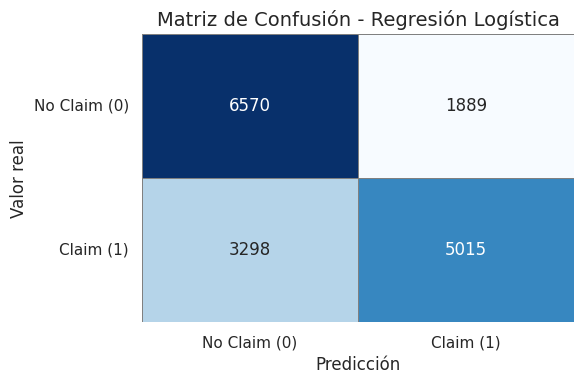

In [152]:
# Calcular matriz de confusión
cm = confusion_matrix(Y_test, predicciones)

# Crear el heatmap con mejor formato
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray')
plt.title('Matriz de Confusión - Regresión Logística', fontsize=14)
plt.xlabel('Predicción', fontsize=12)
plt.ylabel('Valor real', fontsize=12)
plt.xticks([0.5, 1.5], ['No Claim (0)', 'Claim (1)'])
plt.yticks([0.5, 1.5], ['No Claim (0)', 'Claim (1)'], rotation=0)
plt.tight_layout()
plt.show()

Donde:

 - Verdaderos Negativos (TN): 6,570 — Clientes que no aceptaron el producto y fueron correctamente clasificados como negativos.

 - Falsos Positivos (FP): 1,889 — Clientes que no aceptaron el producto, pero el modelo los clasificó incorrectamente como positivos.

 - Falsos Negativos (FN): 3,298 — Clientes que sí aceptaron el producto, pero el modelo no logró identificarlos.

 - Verdaderos Positivos (TP): 5,015 — Clientes que aceptaron el producto y fueron correctamente clasificados.

##Interpretación de los resultados

Esto significa que:

El modelo presenta una buena capacidad para identificar correctamente a los clientes que aceptan el producto, con 5,015 verdaderos positivos, lo cual es relevante para campañas de marketing dirigidas.

Sin embargo, el modelo comete un número considerable de falsos negativos (3,298), lo que implica que una parte importante de clientes potencialmente interesados no está siendo detectada. Esto podría traducirse en oportunidades de negocio perdidas.

Asimismo, existen 1,889 falsos positivos, es decir, clientes que el modelo identifica como propensos a aceptar el producto cuando en realidad no lo hacen. Este comportamiento puede generar costos adicionales asociados a contactos innecesarios en campañas comerciales.